In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import yaml
import copy
import scipy

In [2]:
class LCOEModel:
    """
    Class to reproduce Lazard's LCOE results. Monetary amounts are in millions.
    https://www.lazard.com/media/450784/lazards-levelized-cost-of-energy-version-120-vfinal.pdf
    Construction time does not count because it is included in the capital cost.
    """
    def __init__(self, capacity_mw, capacity_factor, fixed_oam_per_kw, capital_cost_per_kw, lifetime,
                 variable_oam_per_mwh=0, fuel_cost_per_mbtu=0, heat_rate_btu_per_kwh=0, oam_esc_rate=0.0225, debt=0.6,
                 debt_cost=0.08, equity=0.4, equity_cost=0.12, tax_rate=0.4, macrs_schedule=5, tol=1e-3, 
                 irr_years=20, debt_time=None):
        
        self.capacity_mw = capacity_mw
        self.capacity_factor = capacity_factor
        self.fuel_cost_per_mwh = fuel_cost_per_mbtu * heat_rate_btu_per_kwh / 1e9  #/ 1000 / 1e6
        self.fixed_oam_per_kw = fixed_oam_per_kw
        self.variable_oam_per_mwh = variable_oam_per_mwh
        self.capital_cost_per_kw = capital_cost_per_kw
        self.lifetime = lifetime
        self.debt_time = debt_time if debt_time else lifetime
        
        self.oam_esc_rate = oam_esc_rate
        self.debt = debt
        self.debt_cost = debt_cost
        self.equity = equity
        self.equity_cost = equity_cost
        self.tax_rate = tax_rate
        self.macrs_schedule = macrs_schedule 

        self.capex = capital_cost_per_kw * capacity_mw / 1000  # x1000/1e6
        self.loan = debt * self.capex
        
        # values from https://github.com/elasanchez/depreciation-engineering-econ-scripts
        # if I understand well, they are set by law
        self.macrs_dic = {
            3: [0.3333, 0.4445, 0.1481, 0.0741],
            5: [0.2, 0.32, 0.1920, 0.1152, 0.1152, 0.0576],
            7: [0.1429,0.2449, 0.1749, 0.1249, 0.0893, 0.0892, 0.0893, 0.0446],
            10: [0.1, 0.18, 0.144, 0.1152, 0.0922, 0.0737, 0.0655, 0.0655, 0.0656, 0.0655, 0.0328],
            15: [0.05, 0.095, 0.0855, 0.077, 0.0693, 0.0623, 0.059, 0.059, 0.0591, 0.059, 0.0591, 0.059, 0.0591,\
                 0.059, 0.0591, 0.0295],
            20: [0.0375, 0.07219, 0.06677, 0.06177, 0.05713, 0.05285, 0.04888, 0.04522, 0.04462, 0.04461, 0.04462,\
                 0.04461, 0.04462, 0.04461, 0.04462, 0.04461, 0.04462, 0.04461, 0.04462, 0.04461, 0.02231]
        }
        
        self.tol = tol
        self.irr_years = irr_years if irr_years else lifetime
        self.build()
    
    def build(self, lcoe=None):
        years = np.arange(1, self.lifetime + 1)
        df = pd.DataFrame(index=years)
                
        # we start by computing everything we can compute without assuming a LCOE
        df['capacity_mw'] = self.capacity_mw
        df['capacity_factor'] = self.capacity_factor
        df['generation_mwh'] = df.capacity_mw * df.capacity_factor * 24 * 365.25
        
        df['total_fuel_cost'] = self.fuel_cost_per_mwh * df.generation_mwh
        fixed_oam = self.fixed_oam_per_kw * df.capacity_mw / 1000
        variable_oam = self.variable_oam_per_mwh * df.generation_mwh / 1e6
        total_oam_start = fixed_oam + variable_oam
        df['total_oam'] = total_oam_start * (1 + self.oam_esc_rate)**(years - 1)
        df['total_operating_cost'] = df.total_fuel_cost + df.total_oam
        
        df['debt_outstanding'] = self.loan
        df.loc[:self.debt_time, 'debt_interest_expense'] = npf.ipmt(self.debt_cost, df.index[:self.debt_time], self.debt_time, self.loan)
        df.loc[:self.debt_time,'debt_principal_payment'] = npf.ppmt(self.debt_cost, df.index[:self.debt_time], self.debt_time, self.loan)          
        df['levelized_debt_service'] = df.debt_interest_expense + df.debt_principal_payment
        df.loc[2:, 'debt_outstanding'] += df['debt_principal_payment'].cumsum().values[:-1]
        df = df.fillna(0)
        
        depreciation = np.array(self.macrs_dic[self.macrs_schedule]) * self.capex
        padding = [0] * (self.lifetime - self.macrs_schedule - 1) if self.lifetime > self.macrs_schedule else []
        df['depreciation'] = list(-depreciation[:self.lifetime]) + padding
        
        # if a lcoe value is given, we can compute the rest
        if lcoe:
            df['lcoe'] = lcoe
            df['total_revenues'] = df.generation_mwh * df.lcoe / 1e6

            df['ebitda'] = df.total_revenues - df.total_operating_cost
            df['taxable_income'] = df.ebitda + df.depreciation + df.debt_interest_expense
            df['tax_benefit'] = - df.taxable_income * self.tax_rate
            df['net_equity_cash_flow'] = df.ebitda + df.levelized_debt_service + df.tax_benefit
            df.loc[0] = 0
            df.loc[0, 'net_equity_cash_flow'] = - self.capex * self.equity
            df = df.sort_index()
            self.irr_equity_investors = npf.irr(df.loc[:self.irr_years+1, 'net_equity_cash_flow'])
            
        self.df = df
        return self
        
    def find_lcoe(self, debug=False):
        """Optimization by dichotomy. IRR is monotonously increasing with LCOE, which makes it easy."""
        lb, ub = 1, 500
        i = 0
        res = []
        while True:
            lcoe = (lb + ub) / 2
            self.build(lcoe)
            irr = self.irr_equity_investors
            res.append((lcoe, irr))
            if debug:
                print(round(lb, 5), round(ub, 5), end=' ')
                
            if abs(irr - self.equity_cost) < self.tol:
                self.lcoe = lcoe
                break
            elif irr < self.equity_cost or np.isnan(irr):
                # IRR is NaN if too negative
                lb = lcoe
            elif irr > self.equity_cost:
                ub = lcoe
                
            if debug:
                print(round(irr, 5), end=' | ')
                
            if i == 50:
                lcoes, irrs = zip(*res)
                indices = [i for i, irr in enumerate(irrs) if not np.isnan(irr)]
                irrs = np.array(irrs)
                lcoes = np.array(lcoes)
                lcoes = lcoes[indices]
                irrs = irrs[indices]
                loss = np.absolute(irrs - self.equity_cost)
                i = np.argmin(loss)
                self.lcoe = lcoes[i]
                print('IRR did not converge, returning LCOE for IRR = ', irrs[i])                        
                break
                
            i += 1
                
        return self.lcoe
    
    def scan_irrs(self):
        irrs = []
        lcoes =  np.arange(1, 300, 5)
        for lcoe in lcoes:
            self.build(lcoe)
            irrs.append(self.irr_equity_investors)
        return lcoes, irrs
    
    def __repr__(self):
        return pprint.pformat({k: v for k, v in vars(self).items() if k not in ['macrs_dic', 'years', 'df']})

In [3]:
with open('power_plants_v13.yml') as f:
    power = yaml.safe_load(f)
    
with open('lazard_estimates_v13.yml') as f:
    lazard = yaml.safe_load(f)

In [6]:
for k, v in power.items():
    print(' '.join(k.split('_')).capitalize())
    model = LCOEModel(**v['low'])
    print('\tMine:\t', round(model.find_lcoe()), end= ' - ')
    model = LCOEModel(**v['high'])
    print(round(model.find_lcoe()))
    print('\tLazard:\t {} - {}'.format(lazard[k]['low'], lazard[k]['high']))

Gas combined cycle
	Mine:	 42 - 67
	Lazard:	 44 - 68
Pv community
	Mine:	 67 - 155
	Lazard:	 64 - 148
Pv utility crystalline
	Mine:	 37 - 46
	Lazard:	 36 - 44
Wind onshore
	Mine:	 29 - 58
	Lazard:	 28 - 54
Geothermal
	Mine:	 72 - 118
	Lazard:	 69 - 112
Nuclear
	Mine:	 121 - 198
	Lazard:	 118 - 192
Gas peaking
	Mine:	 151 - 204
	Lazard:	 150 - 199
Pv utility thin film
	Mine:	 35 - 42
	Lazard:	 32 - 42
Pv rooftop cai
	Mine:	 79 - 163
	Lazard:	 75 - 154
Coal
	Mine:	 66 - 155
	Lazard:	 66 - 152
Pv rooftop residential
	Mine:	 159 - 255
	Lazard:	 151 - 242
Solar thermal
	Mine:	 135 - 165
	Lazard:	 126 - 156
Wind offshore
	Mine:	 68 - 122
	Lazard:	 64 - 115


### A few trials

In [5]:
model = LCOEModel(**power['wind_onshore']['high'], macrs_schedule=20)
model.find_lcoe()

71.6591796875

In [6]:
model.build(57.5)
npf.npv(0.12, model.df.net_equity_cash_flow)

-31.34049233059311

In [7]:
def df_to_markdown(df, float_format='%.2g'):
    """
    Export a pandas.DataFrame to markdown-formatted text.
    DataFrame should not contain any `|` characters.
    """
    from os import linesep
    return linesep.join([
        '|'.join(df.columns),
        '|'.join(4 * '-' for i in df.columns),
        df.to_csv(sep='|', index=False, header=False, float_format=float_format)
    ]).replace('|', ' | ')

In [8]:
model = LCOEModel(**power['wind_onshore']['high'])
model.find_lcoe()
r = 0.12
npf.npv(r, model.df.net_equity_cash_flow[1:7]) / npf.npv(r, model.df.net_equity_cash_flow[1:])

0.9257752166155484

### My estimates

In [17]:
techs = ['nuclear', 'wind_onshore', 'pv_utility_thin_film']
p = {k: v.copy() for k, v in copy.deepcopy(power).items() if k in techs}

In [18]:
for k, v in p.items():
    for k2, v2 in v.items():
        v2['irr_years'] = None

In [19]:
for k, v in p.items():
    print(' '.join(k.split('_')).capitalize(), ':', end= ' ')
    model = LCOEModel(**v['low'])
    print(round(model.find_lcoe()), end= ' - ')
    model = LCOEModel(**v['high'])
    print(round(model.find_lcoe()))

Pv utility thin film : 35 - 42
Nuclear : 119 - 194
Wind onshore : 29 - 58


In [20]:
p['wind_onshore']['low']['capacity_factor'] = 0.5
p['wind_onshore']['high']['capacity_factor'] = 0.25
p['pv_utility_thin_film']['low']['capacity_factor'] = 0.25
p['pv_utility_thin_film']['high']['capacity_factor'] = 0.15

In [21]:
print('Estimates - real capacity factor and lifetime')
for k, v in p.items():
    print(' '.join(k.split('_')).capitalize(), ':', end= ' ')
    model = LCOEModel(**v['low'])
    print(round(model.find_lcoe()), end= ' - ')
    model = LCOEModel(**v['high'])
    print(round(model.find_lcoe()))

Estimates - real capacity factor and lifetime
Pv utility thin film : 48 - 64
Nuclear : 119 - 194
Wind onshore : 32 - 87


In [38]:
print('Estimates - 20 year MACRS')
for k in ['wind_onshore', 'pv_utility_thin_film']:
    v = p[k]
    print(k, end=' ')
    for k2 in ['low', 'high']:
        d = copy.deepcopy(v[k2])
        model = LCOEModel(**d, macrs_schedule=20)
        if k2 == 'low':
            print(round(model.find_lcoe()), end=' - ')
        else:
            print(round(model.find_lcoe()))

Estimates - 20 year MACRS
wind_onshore 40 - 109
pv_utility_thin_film 62 - 84


### Plot of cash flow

In [13]:
wind_model = LCOEModel(**p['wind_onshore']['low'])
wind_model.find_lcoe()
solar_model = LCOEModel(**p['pv_utility_thin_film']['low'])
solar_model.find_lcoe()
nuclear_model = LCOEModel(**p['nuclear']['low'])
nuclear_model.find_lcoe()

118.927734375

In [25]:
def normalize(s):
    return - s / s[0]

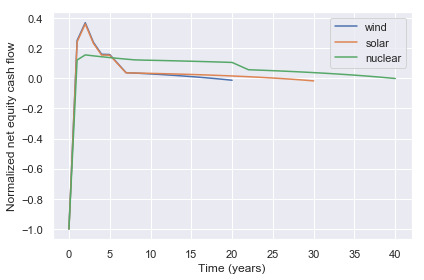

In [15]:
fig, ax = plt.subplots()
ax.plot(normalize(wind_model.df.net_equity_cash_flow), label='wind')
ax.plot(normalize(solar_model.df.net_equity_cash_flow), label='solar')
ax.plot(normalize(nuclear_model.df.net_equity_cash_flow), label='nuclear')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Normalized net equity cash flow')
ax.legend(loc=0)
fig.tight_layout()
#fig.savefig('norm_cash_flow.svg')
plt.show()

### Changing the cost of capital

In [13]:
capital_cost = [(0.01, 0.02), (0.02, 0.03), (0.02, 0.05), (0.03, 0.06), (0.05, 0.09), (0.06, 0.1), (0.08, 0.12)]
waccs =  [0.5*equity_cost + 0.6*debt_cost*0.6 for debt_cost, equity_cost in capital_cost]

In [14]:
a = {}
for k, v in p.items():
    a[k] = {'low': [], 'high': []}
    for k2 in ['low', 'high']:
        d = copy.deepcopy(v[k2])
        for debt_cost, equity_cost in capital_cost:
            d['debt_cost'] = debt_cost
            d['equity_cost'] = equity_cost
            model = LCOEModel(**d)
            lcoe = model.find_lcoe()
            a[k][k2].append(lcoe)

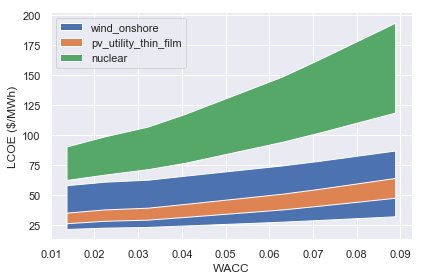

In [16]:
fig, ax = plt.subplots()
energies = ['wind_onshore', 'pv_utility_thin_film','nuclear']
for k in energies:
    v = a[k]
    y1 = v['low']
    y2 = v['high']
    ax.fill_between(waccs, y1, y2, label=k)

ax.set_ylabel('LCOE ($/MWh)')
ax.set_xlabel('WACC')
ax.legend(loc=2)
fig.tight_layout()
fig.savefig('sensitivity_to_capital.svg')

plt.show()

In [61]:
debt = 0.6
debt_cost = 0.02
equity = 1 - debt
equity_cost = 0.03
print('WACC:', equity*equity_cost + debt*debt_cost*0.6)

WACC: 0.019200000000000002


In [62]:
print('Estimates - different capital cost')
for k, v in p.items():
    print(k, end=' ')
    for k2 in ['low', 'high']:
        d = copy.deepcopy(v[k2])
        d['debt'] = debt
        d['debt_cost'] = debt_cost
        d['equity'] = equity
        d['equity_cost'] = equity_cost
        model = LCOEModel(**d)
        if k2 == 'low':
            print(round(model.find_lcoe()), end=' - ')
        else:
            print(round(model.find_lcoe()))

Estimates - different capital cost
wind_onshore 23 - 61
pv_utility_thin_film 29 - 38
nuclear 67 - 99


### Loan duration

In [110]:
n = 60
pv = 9000
npf.pmt(0.08, n, pv) * n

-43630.892332368654

In [22]:
wind_model = LCOEModel(**p['wind_onshore']['low'], debt_time=8)
print(wind_model.find_lcoe())
solar_model = LCOEModel(**p['pv_utility_thin_film']['low'], debt_time=8)
print(solar_model.find_lcoe())
nuclear_model = LCOEModel(**p['nuclear']['low'], debt_time=25)
print(nuclear_model.find_lcoe())

38.5224609375
64.349609375
126.724609375


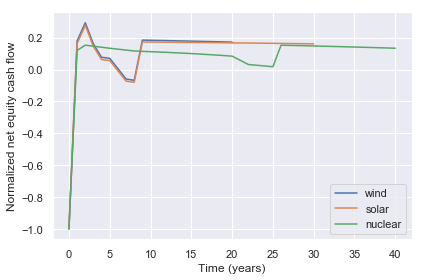

In [27]:
fig, ax = plt.subplots()
ax.plot(normalize(wind_model.df.net_equity_cash_flow), label='wind')
ax.plot(normalize(solar_model.df.net_equity_cash_flow), label='solar')
ax.plot(normalize(nuclear_model.df.net_equity_cash_flow), label='nuclear')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Normalized net equity cash flow')
ax.legend(loc=0)
fig.tight_layout()
fig.savefig('norm_cash_flow_2.svg')
plt.show()

In [49]:
debt = 0.6
debt_cost = 0.02
equity = 1 - debt
equity_cost = 0.03
print('WACC:', equity*equity_cost + debt*debt_cost*0.6)

WACC: 0.019200000000000002


In [50]:
print('Estimates - different capital cost with amortization')
for k, v in p.items():
    print(k, end=' ')
    debt_time = 25 if k == 'nuclear' else 8
    for k2 in ['low', 'high']:
        d = copy.deepcopy(v[k2])
        d['debt'] = debt
        d['debt_cost'] = debt_cost
        d['equity'] = equity
        d['equity_cost'] = equity_cost
        model = LCOEModel(**d, debt_time=debt_time)
        if k2 == 'low':
            print(round(model.find_lcoe()), end=' - ')
        else:
            print(round(model.find_lcoe()))

Estimates - different capital cost with amortization
pv_utility_thin_film 32 - 43
nuclear 70 - 104
wind_onshore 24 - 65


In [31]:
for lifetime in [40, 60, 80]:
    print(lifetime, end=' : ')
    for k in ['low', 'high']:
        v = p['nuclear'][k]
        d = copy.deepcopy(v)
        d['lifetime'] = lifetime
        d['debt'] = debt
        d['debt_cost'] = debt_cost
        d['equity'] = equity
        d['equity_cost'] = equity_cost
        model = LCOEModel(**d, debt_time=25)
        if k == 'low':
            print(round(model.find_lcoe()), end=' - ')
        else:
            print(round(model.find_lcoe()))

40 : 70 - 104
60 : 68 - 99
80 : IRR did not converge, returning LCOE for IRR =  0.07782909273875593
88.0 - 100


## A few tests

In [122]:
debt = 0.6
debt_cost = 0.02
equity = 1 - debt
equity_cost = 0.03
print('WACC:', equity*equity_cost + debt*debt_cost*0.6)

WACC: 0.019200000000000002


-4.734992102133139